# Word Co-occurrence Analysis

On this notebook I will work my way through a word co-occurrence analysis with python and scikit. By the end, our result will be a graph depicting word relationships based on document co-occurrence. This was inspired by the R tutorial series [Text Mining for Social Scientists and Digital Humanists](https://tm4ss.github.io) by Gregor Wiedemann.

The dataset contains 12,435 medical package insert documents.  This is a private dataset, so I won't be able to make it available, but the technique can be replicated with your own corpus without a lot of modification.

In [1]:
import pandas as pd
import morph
import csv

## Understanding the Data

The original data is composed of 8 columns. The first two are the document id and the group it belongs to. We don't need these for our analysis. The rest contain information like side-effects, intake, special considerations during pregnancy, etc. 

Since this dataset is in Japanese, the text pre-processing that takes place is a little different than usual. There is no need to perform (explicit) stemming or lemmatization. We could apply lowercase conversion, given that there are [full-width](https://en.wikipedia.org/wiki/Halfwidth_and_fullwidth_forms) roman letters in the data set (e.g.: Ｔｏｘｉｃ　Ｅｐｉｄｅｒｍｉｃ　Ｎｅｃｒｏｌｙｓｉｓ) but for the purpose of this simple analysis, we'll assume we are only working with japanese words. 

That being said, the tokenization of Japanese text is more complicated than its English counterpart, mainly because japanese sentences are not space-segmented. I will use [MeCab](http://taku910.github.io/mecab/) in order to perform morphological analysis and extract only the Parts of Speech we're interested in (nouns in this case). The method "mecabify" is included in "morph".

## Word co-occurrence (?)

In linguistics, co-occurrence (coincidence, concurrence) refers to an above average frequency of two words from a text corpus alongside each other.   It can be interpreted as an indicator of semantic proximity (similar meaning). However, there is no strict definition as to what can be considered as a co-occurrence; Concurrence can be considered as mutual appereance on: Sentences, paragraphs, book chapters or even whole documents. For this analysis we will work at the sentence  scope.  Let's split all the documents into sentences delimited by the 。character.  Text segmentantion is usually not this trivial, but it's a good start for our purpose.

In [2]:
data = pd.read_csv("data/bunsho.csv", delimiter=',', na_filter=False)
documents = []
for i,row in data.iterrows():
    if(i%1000 == 0):
        print "Analyzed: " + str(i) + "/" + str(len(data)) + " items."
    for x in range(2,8):
        if row[x] != "":
            for sentence in row[x].split('。'):
                documents.append(morph.mecabify(sentence,False,False))

Analyzed: 0/12435 items.
Analyzed: 1000/12435 items.
Analyzed: 2000/12435 items.
Analyzed: 3000/12435 items.
Analyzed: 4000/12435 items.
Analyzed: 5000/12435 items.
Analyzed: 6000/12435 items.
Analyzed: 7000/12435 items.
Analyzed: 8000/12435 items.
Analyzed: 9000/12435 items.
Analyzed: 10000/12435 items.
Analyzed: 11000/12435 items.
Analyzed: 12000/12435 items.


We end up with this many documents in our corpus:

In [3]:
print "corpus size: " , len(documents)

corpus size:  594815


In [4]:
for doc in documents[2000:2005]: print doc

次 副作用 症状 適切処置
譫妄 精神神経 頻度不明激越
循環器 頻度不明不整脈 血圧変動 ＳＴ低下 心電図異常 徐脈 脈
機能異常 ＡＬＴ上昇 肝臓 ＡＳＴ上昇 ＧＰＴ上昇 ＧＯＴ上昇 頻度不明
嘔吐 消化器 頻度不明悪心


There is some noise due to the underlying document format (eg.: section headlines, overlooked stopwords, etc.), however, some sentences accurately depict the relationship between words. For example: 
機能異常 ＡＬＴ上昇 肝臓 ＡＳＴ上昇 ＧＰＴ上昇 ＧＯＴ上昇 頻度不明  where an abnormal function of the liver can lead to increased ALT, AST, etc. levels. Also, 循環器 頻度不明不整脈 血圧変動 ＳＴ低下 心電図異常 徐脈 脈 : Circulatory organ, irregular pulse, change in blood pressure, ST depression, Irregularities in electrocardiogram, bradycardia.

## Word count

To begin, we will count how many times a word appears per document, effectively building a document-term-matrix. [Wikipedia](https://en.wikipedia.org/wiki/Document-term_matrix) defines a dtm as a mathematical matrix that describes the frequency of terms that occur in a collection of documents. Rows correspond to documents in the collection, and columns correspond to terms. We will use the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) from sckikit.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

Stop words are words which are filtered out before natural language data processing. The term usually refers to the most common words in a language, but there is no single universal list of stop words used by all natural language processing tools. For this analysis I used a list of japanese stopwords and extended it with some words that made no sense for my application (Like some specific proper nouns, named entities, etc.). Indeed, the list of stopwords depends on what you want to achieve, but the list of english stopwords from nltk is very commonly used, in case you need something as a starter point.

In [6]:
stopwords_file = "data/stopwords.txt"
stopwords  = pd.read_csv(stopwords_file, delimiter=',', na_filter=False)["stopwords"]

The function below is the custom [tokenizer](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization) we pass to CountVectorizer. In our case, MeCab already did all the work, so we will only use it to remove stopwords.

We could've passed the mecabify function here as well, but I preferred to have it separatedly in order to:

- Control the document definition (Sentences)
- Save the pre-processed corpus

The last item intends to reduce the time used for the mecab analysis, for example, when new stopwords are added, there is no need to re-split the documents into sentences with space separated words.



In [7]:
def space_break(text):
    words  = text.split()
    for w in words:
        if w not in stopwords:
            yield w

Count Vectorizer will take the corpus as input and output a dtm. max_df and min_df allow us to ignore words that appear in too many documents (think of it as a low variance feature) or in too few ones (think of a variable that is unique to a sample, such as an ID).

A value between 0 and 1 represents a percentage (i.e.: max_df = 0.75 means ignore words that appear in more than 75% of the documents) while an integer represents a fixed number of documents (i.e.: min_df = 5 means ignore words that appear in less than 5 documents).

For our analysis we want to relax the lower bound, since there are cases of uncommon side-effects and diseases that we still want to include. 

In [8]:
vectorizer = CountVectorizer(max_df=0.75, min_df=5, analyzer = space_break, stop_words = stopwords,lowercase=False)
dtm = vectorizer.fit_transform(documents)
features = vectorizer.get_feature_names()

In [9]:
dtm.shape

(594815, 24840)

The dtm matrix contains 594815 rows. One for each document in the corpus.<br/>
It also has 24840 columns, corresponding to all the extracted words.<br/> 
The number in the position X[i,j] represents how many times a word appears in a document.

As you might've guessed, most of the matrix values are actually zero, and this is known as a [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix).  A sparse matrix can be represented as a dictionary of coordinates and values, to save space in memory. For display purposes, or custom operations, it can be coerced into a dense matrix, but depending on its dimensions, it might cause memory problems, so be careful.

The _features_ list contains all the extracted words. This can be used as an index of the X matrix columns. 

In [10]:
for x in features[12000:12010]: print x

感染
感染ボランティア
感染リスク
感染予防
感染初期
感染巣
感染性
感染性ぶどう膜炎
感染性ショック
感染性下痢患者


### Creating a Co-occurence Matrix

To create a co-occurence matrix in which both rows and columns are indexed by the extracted words, and the i,j intersection represents in how many documents they appear together, we simply multiply the dtm Matrix by its transpose (not in that order :p). 

In [11]:
cooc = (dtm.T * dtm)
cooc.shape

(24840, 24840)

## Word Similarity Measures

In order to not only count joint occurrence we have to determine word similarity.

An excerpt from [Measuring Semantic Similarity between Words Using Web Documents](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.174.6869&rep=rep1&type=pdf) helps us understand _how_.

_Maintaining an up-to-date taxonomy of all the new words and new usages of existing words is difficult and costly. [...] Danushka Bollegala has proposed similarity measures using page count returned by a search engine for the given word pair. These similarity measures are modified four popular co-occurrence measures; **Jaccard, Overlap, Dice, and PMI (point-wise mutual information)**. Page-count-based metrics use association ratios between words that are computed using their co-occurrence frequency in documents. The basic assumption of this approach is that high co-occurrence frequencies indicate high association ratios and high association ratios indicate a semantic relation between words._

Let's use one of the propsed metrics in the paper to find related words in our documents. Some of the parameters used by Jaccard similarity (and most of the metrics) are as follows:

In [12]:
#Term of interest 
term = "エイズ"

#Corpus Size (Scalar)
k = (dtm.shape[0])

# Term of interest Frequency (Scalar) (Times our term of interest appears in all the documents)
ki = dtm[:,features.index(term)].sum()  #Equivalent to cooc[features.index(term),features.index(term)]

# All Term Frequency Counts (Vector).   (Times every term appears in all the documents)
kj = cooc.diagonal()   #Equivalent to dtm.sum(axis=0)

#Term co-occurence Counts　(Vector) (Times every term co-occurs with our term of interest)
kij = cooc[features.index(term), ]

### Jaccad Similarity

Jaccard similarity coefficient is a statistic used for comparing the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets. Using the values we calculated for the term エイズ we get:

In [15]:
import numpy as np
jaccard = kij / (ki + kj - kij)

In [16]:
scores = pd.Series(np.squeeze(np.asarray(jaccard)), index = features)
scores.sort_values(ascending=False).head(15)

エイズ                          1.000000
後天性免疫不全症候群                   0.846154
播種性ＭＡＣ症                      0.348837
ＭＡＣ                          0.219020
播種性マイコバクテリウム・アビウムコンプレックス     0.204893
臨床的細菌学的改善                    0.176000
偏執反応                         0.146154
神経過敏症                        0.140741
膣トリコモナス症                     0.112000
播種性マイコバクテリウム・アビウムコンプレックス症    0.112000
淋病                           0.112000
性感染症                         0.107692
クラミジア感染症                     0.103704
圭コンジローマ                      0.097902
頻度不明不眠症                      0.095238
dtype: float64

And now we have a list of jaccard similarity for the term AIDS. How are there words related to AIDS? You might ask, well, 後天性免疫不全症候群  stands for Acquired ImmunoDeficiency Syndrome, 播種性ＭＡＣ症  MAC (Mycobacterium avium Complex) Disease is one of the [opportunistic infections](https://aidsinfo.nih.gov/guidelines/html/4/adult-and-adolescent-opportunistic-infection/326/mac) AIDS patients usually come down with.  クラミジア感染症 Chlamydia is also an STD...  and so on! 

Note that AIDS has a Jaccard similarity of 1 with itself. We will deal with that when we visualize the connections on the next step.

## Visualization

We can visualize the co-occurence metrics with a network in which the nodes represent terms and the edges the connections between them.

In [17]:
def jaccard(k,ki,kj,kij):
    return  kij / (ki + kj - kij)

The function below will allow us to calculate the term similarities for an input term using whatever metric we define. We'll stick with Jaccard for now.

In [18]:
def get_distances(term, num_terms, metric):

    term_index = features.index(term)
    k = (dtm.shape[0])
    ki = cooc[term_index,term_index]
    kj = cooc.diagonal() 
    kij = cooc[term_index, ]
        
    scores = metric(k,ki,kj,kij)
    scores = pd.Series(np.squeeze(np.asarray(scores)), index = features)
    scores = scores.sort_values(ascending=False).head(num_terms)
    return scores

To acquire an extended "field of vision", co-occurrence terms can be computed for each co-occurrence term of the target term up to whatever depth we want. This results in a graph that can be visualized with a Force Directed Graph.

In [19]:
def expand_term(term, num_terms, depth, metric):
    distances = {}
    pending = [term]
    for _ in range(depth):
        queue = pending
        for current_term in queue:
            pending.remove(current_term)
            if current_term not in distances:
                distances[current_term] = get_distances(current_term, num_terms,metric)
                pending = pending + list(distances.get(current_term).index)
    return distances

The function below will stack all the calculated similarity vectors together to build a matrix of similarities.  Think of it as a kind of correlation matrix. 

In [20]:
def buid_dist_matrix(term, num_terms, depth, metric):
    all_terms = expand_term(term, num_terms,depth,metric)
    rel_mat = pd.DataFrame(0, index=all_terms.keys(), columns=all_terms.keys())
    for term, distances in all_terms.items():
        indexer = list(set(distances.index).intersection(set(rel_mat.index)))
        rel_mat.loc[term,indexer] = distances[indexer]
        
    return rel_mat

In [21]:
buid_dist_matrix("エイズ",5,3,jaccard).iloc[0:5,0:5]

,ＭＡＣ,症,後天性免疫不全症候群,臨床的細菌学的改善,播種性マイコバクテリウム・アビウムコンプレックス
ＭＡＣ,1.000000,0.107568,0.225519,0.0,0.902685
症,0.107568,1.000000,0.000000,0.0,0.000000
後天性免疫不全症候群,0.225519,0.000000,1.000000,0.0,0.211356
臨床的細菌学的改善,0.000000,0.000000,0.191304,1.0,0.000000
播種性マイコバクテリウム・アビウムコンプレックス,0.902685,0.104062,0.211356,0.0,1.000000


A graph object can be created from a three-column dataframe that encodes an edge-information of two nodes (source, target) and an edge-weight value. We can get such a dataframe from our "correlation metrix" like so:

In [22]:
links = buid_dist_matrix("エイズ",6,3,jaccard).stack().reset_index()
links.columns = ['src', 'tgt','wt']
links.head()

,src,tgt,wt
0,ＭＡＣ,ＭＡＣ,1.000000
1,ＭＡＣ,症,0.107568
2,ＭＡＣ,劇症,0.000000
3,ＭＡＣ,紫斑皮疹,0.073826
4,ＭＡＣ,後天性免疫不全症候群,0.225519


Now, the expand_term functions allows us to extract a fixed number of terms out of the top most similar terms to our input. An alternative is to get only those terms that have a strong or significant similarity. We would need to establish a cutoff value for that. 

Instead, for this analysis, let's just remove any relations with Jaccard similarity less than 0.2. Also, we should remove similarities of 1 (term with itself)

In [23]:
links_filtered = links.loc[ (links['wt'] > 0.2) & (links['src'] != links['tgt']) ]
links_filtered.is_copy = False

#Matplotlib will complain that it can't plot our strings. Moral of the story: Use Python 3.
links_filtered["src"] = links_filtered["src"].apply(lambda x: x.decode('utf8'))
links_filtered["tgt"] = links_filtered["tgt"].apply(lambda x: x.decode('utf8'))

Finally, we can build our graph with the filtered links.

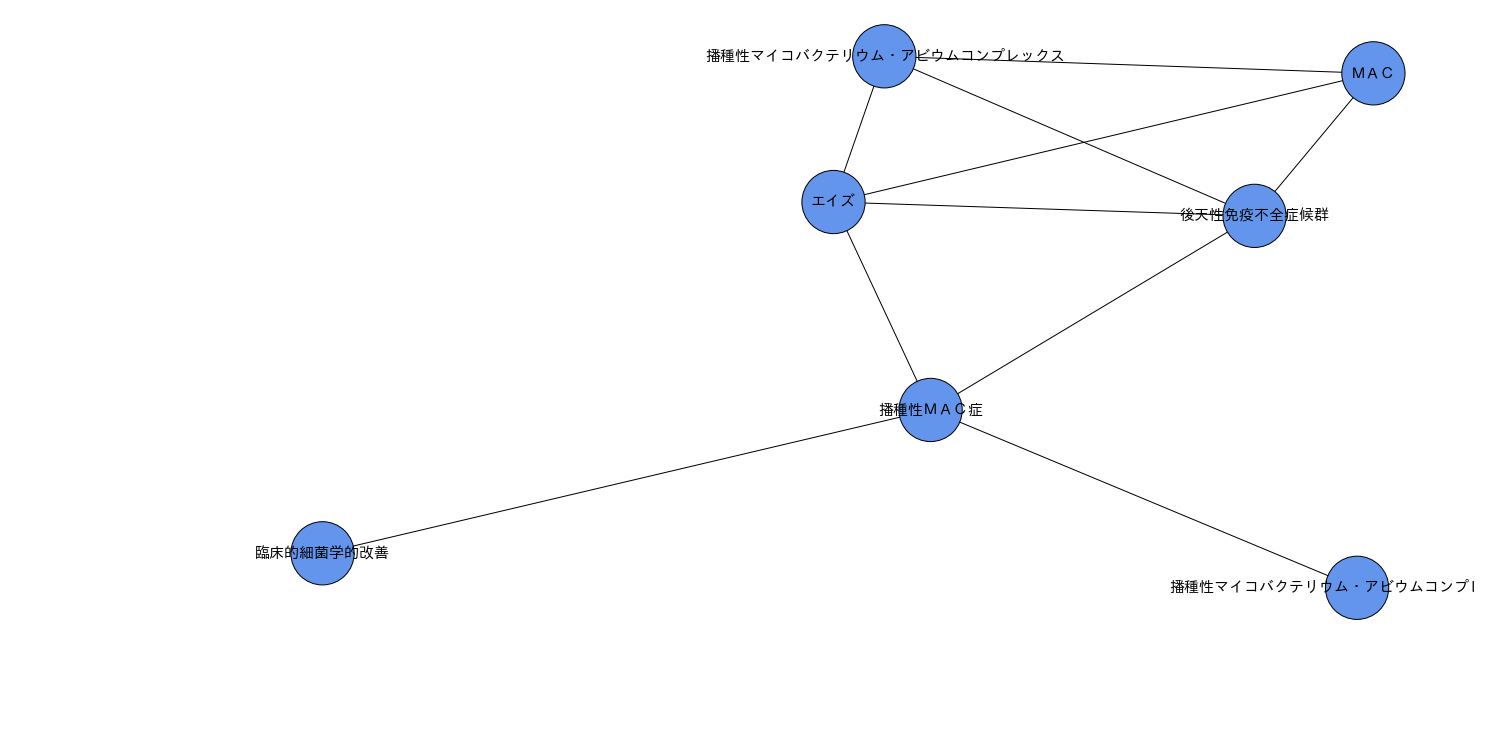

In [26]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
 
G=nx.from_pandas_edgelist(links_filtered, 'src', 'tgt', 'wt')

plt.figure(figsize=(20,10))
#I suspect the draw method uses a force directed algorithm and therefore everytime we call it a different graph is printed. 
#The random seed prevents this, in case you want consistency
np.random.seed(4)
nx.draw(G, with_labels=True, node_color='cornflowerblue', node_size=4000, edge_color='black', linewidths=1, font_size=15, font_family="IPAexGothic")

We can tweak the call to the draw method to try and input more information into our graph.

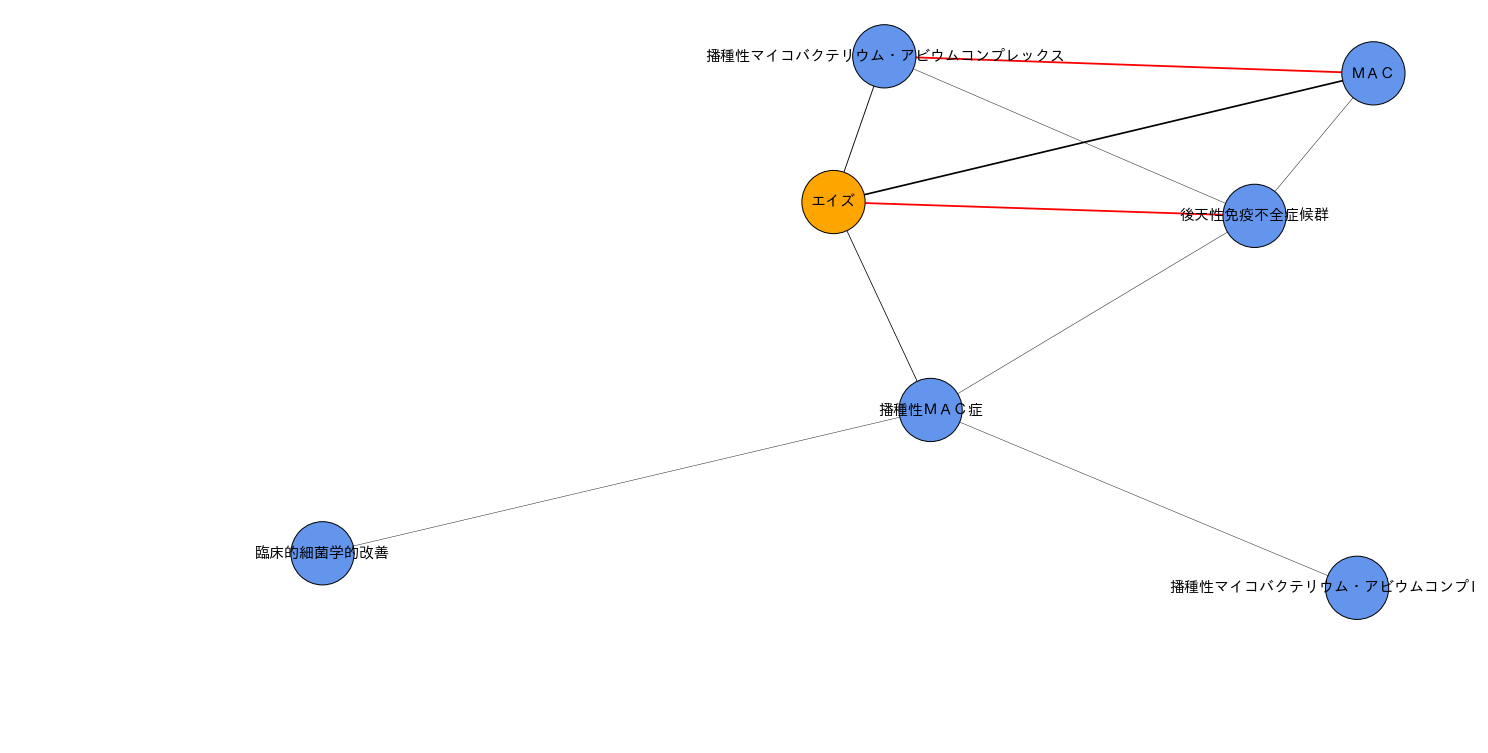

In [27]:
plt.figure(figsize=(20,10))
np.random.seed(4)
nx.draw(G, 
        with_labels=True, 
        node_color=['cornflowerblue' if n != u'エイズ' else 'orange' for n in G.nodes ] , 
        node_size=4000, 
        linewidths=1, 
        font_size=15, 
        font_family="IPAexGothic",
        width = list(links_filtered["wt"]*2),
        edge_color = ["r" if e[2]["wt"] > 0.8 else "k" for e in G.edges(data=True)])


In the above graph the width of our edges is a function of their weight. Moreover, if the weight is over 0.8, it is painted red. Also, the root node is colored diferently. 

There are still many improvements for this analysis. Removing prefixes and suffixes as part of the mecabify process or the stopword pruning process would help with the almost identical terms. Speaking of almost identical, this dataset contains documents that are almost alike, except for minor formatting (bullets/numbers, extra two or three sentences). We could try synthetizing those into a single document to reduce redundancy.